In [1]:
#from operator import itemgetter
import sys
import os
import tensorflow as tf
import pandas as pd
import sklearn
import random
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tensorflow import keras
import keras_tuner as kt

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13524036148277234962
xla_global_id: -1
]


In [127]:
def encode_gait_percentage(df, name):
  percent = df[name].values.tolist();
  x = np.zeros((len(df[name]),1))
  y = np.zeros((len(df[name]),1))
  for i in range (len(percent)): 
    phi = percent[i] * 2 * math.pi / 100
    x[i] = math.cos(phi)
    y[i] = math.sin(phi)
    
  df['x'] = x
  df['y'] = y

In [128]:
working_dir = os.path.dirname(os.getcwd())
sys_platform = sys.platform
excel_path_dict = {'linux' : "/csvs/", 'win32' : "\Data\SPT\\"}
excel_path_name = excel_path_dict[sys_platform]

directory_path = working_dir 
print(directory_path)
excel_path = directory_path + excel_path_name

excel_name = 'TH_new.xlsx' 

source_table = pd.read_excel(excel_path + excel_name, sheet_name='raw_data')

source_table.keys()
angle_raw_dict = source_table

c:\Users\Admin\Desktop\Neurorobotic Lab\Data_Code


In [129]:
angle_raw_dict = source_table
angle_raw_dict = angle_raw_dict[angle_raw_dict.perc >= 0]
angle_raw_dict = angle_raw_dict[angle_raw_dict.perc <= 99]
angle_raw_dict.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91391 entries, 0 to 92584
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   l_hip    91391 non-null  float64
 1   l_foot   91391 non-null  float64
 2   l_shank  91391 non-null  float64
 3   perc     91391 non-null  float64
 4   l_grf    91391 non-null  float64
 5   r_grf    91391 non-null  float64
 6   r_hip    91391 non-null  float64
 7   r_foot   91391 non-null  float64
 8   r_shank  91391 non-null  float64
 9   r_cop    91391 non-null  float64
 10  l_cop    91391 non-null  float64
dtypes: float64(11)
memory usage: 8.4 MB


Reading from excel. Converting to numpy

In [130]:
train_data_x=angle_raw_dict
#label_strike(angle_raw_dict,'perc')

encode_gait_percentage(angle_raw_dict,'perc')

train_data_x = train_data_x.drop(["perc","x","y"], axis=1)


In [131]:
print(train_data_x)

          l_hip     l_foot   l_shank     l_grf       r_grf     r_hip  \
0      29.38855  -9.801311  7.003011  3.910719   92.860370  2.003097   
1      29.29255  -9.728311  6.852691  4.491501   92.295360  1.878497   
2      29.17415  -9.568311  6.687501  5.066542   91.682630  1.755597   
3      29.04015  -9.321311  6.506911  5.627588   91.026163  1.639297   
4      28.89835  -9.072311  6.311381  6.175027   90.329292  1.533797   
...         ...        ...       ...       ...         ...       ...   
92580  41.57125  -9.176311 -2.636449  0.000000  107.714093 -0.513303   
92581  41.47175 -10.833311 -1.667329  0.000000  108.287418 -0.784003   
92582  41.36125 -12.374311 -0.745199  0.000000  108.569265 -1.060603   
92583  41.21225 -13.967311  0.212941  0.000000  108.533762 -1.346703   
92584  41.02055 -15.650311  1.254101  0.000000  108.160508 -1.624703   

         r_foot    r_shank     r_cop     l_cop  
0      2.444692  -8.982086  0.001629  0.093431  
1      2.291192  -9.277516  0.002410 

In [132]:
train_data_y = angle_raw_dict[["x","y"]]
#train_data_y = angle_phase_dict[["x","y"]]


In [133]:
print(train_data_y.shape)
type(train_data_y)


(91391, 2)


pandas.core.frame.DataFrame

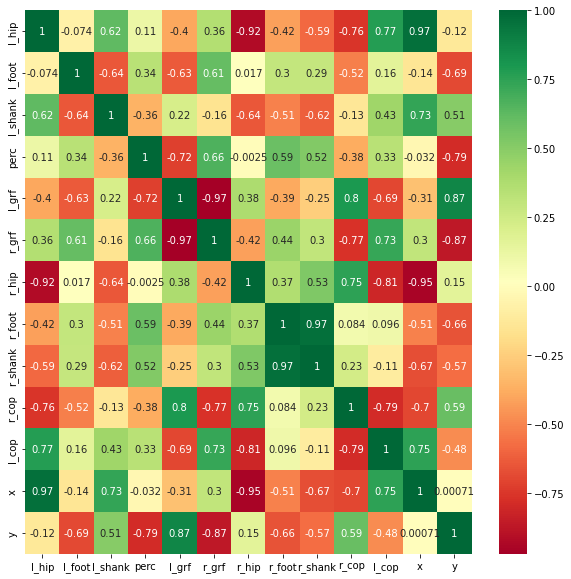

In [134]:
import seaborn as sns
corrmat = angle_raw_dict.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
g=sns.heatmap(angle_raw_dict[top_corr_features].corr(),annot=True,cmap="RdYlGn")

Splitting data into training and testing sets

In [135]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(train_data_x)

train_data_y= train_data_y.values.reshape(-1,2)
#print(train_data_y)

X, X_test, Y, y_test = train_test_split(X_scaled, train_data_y, test_size=0.15, shuffle=False)
#X, X_test, Y, y_test = train_test_split(train_data_x, train_data_y, test_size=0.15, shuffle=False)

In [136]:
X_train, x_val, y_train, y_val = train_test_split(X, Y, test_size = 0.15, shuffle = False)

In [137]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(66029, 10)
(13709, 10)
(66029, 2)
(13709, 2)


Models

In [16]:
def model_builder(hp):
    
    # first layer of the model
    model = keras.Sequential([tf.keras.layers.InputLayer(input_shape= X_train.shape[1],)])

    # specifying the min and max nodes for hidden layer
    hp_units = hp.Int('units', min_value=10, max_value=100)
    model.add(keras.layers.Dense(units= hp.Int('units', min_value=10, max_value=100), activation='relu'))

    #model = keras.Sequential([tf.keras.layers.InputLayer(input_shape=14 ,)])
    # specifying the min and max nodes for hidden layer
    #hp_units_2 = hp.Int('units', min_value=10, max_value=150)
    model.add(keras.layers.Dense(units= hp.Int('units_2', min_value=10, max_value=100), activation='relu'))
    
    # output layer
    model.add(keras.layers.Dense(2))

    #compiling the model
    model.compile(optimizer=keras.optimizers.Adam(),
                    loss=tf.keras.losses.mae,
                    metrics=['mse'])
    return model

# initializing the tunner 
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     overwrite=True
                    )
# Early stopping in keras
stop_early = EarlyStopping(monitor='val_loss', patience = 3, verbose = 1)

# Seaching the tunner 
tuner.search(X_train, y_train, validation_split=0.15, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

tuner.results_summary()

# printing the optimal number of nodes 
print('The optimal number of node in the hidden layer is: ', best_hps.get('units'))
#print('The optimal number of node in the hidden layer 2 is: ', best_hps_2.get('units'))

Trial 254 Complete [00h 01m 11s]
val_loss: 0.05040040984749794

Best val_loss So Far: 0.03206587955355644
Total elapsed time: 13h 17m 48s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in .\untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
units: 91
units_2: 85
tuner/epochs: 12
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.03206587955355644
Trial summary
Hyperparameters:
units: 66
units_2: 60
tuner/epochs: 12
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.032987479120492935
Trial summary
Hyperparameters:
units: 94
units_2: 97
tuner/epochs: 12
tuner/initial_epoch: 4
tuner/bracket: 4
tuner/round: 2
tuner/trial_id: 0116
Score: 0.03309956192970276
Trial summary
Hyperparameters:
units: 92
units_2: 95
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 0145
Score: 0.03321107104420662
Trial summary
Hyperparameters:
units: 97
units_2: 72
tuner/epochs: 34
tuner/initial_epoch: 12
tuner/br

In [19]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print('The optimal number of node in the hidden layer is: ', best_hps.get('units'))

The optimal number of node in the hidden layer is:  91


In [138]:
# Use MSE loss since it is a regression problem
#model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mae','mse'])

# Stop training when model stops improving
#monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=15, verbose=1, mode='auto')
#opt = keras.optimizers.Adam(learning_rate=0.001)
for i in range(1):
  print('\nRun: ', i + 1)
  checkpointer = ModelCheckpoint(filepath=os.path.join("simple.hdf5"), 
                               verbose=0, save_best_only=True)

  model = Sequential() # simplest model - with single stack of layers

  model.add(Dense(100, input_dim=X_train.shape[1], activation='relu'))
  model.add(Dense(50, activation='relu'))
  model.add(Dense(2))

  # Use MSE loss since it is a regression problem
  model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mae','mse'])

  # Stop training when model stops improving
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=20, verbose=1, mode='auto')

  epoch=model.fit(X_train, y_train, validation_data=(x_val, y_val), batch_size=64,
          callbacks=[monitor,checkpointer], verbose=1, epochs= 25)


Run:  1
Epoch 1/25
1032/1032 [==============================] - 7s 5ms/step - loss: 0.0113 - mae: 0.0611 - mse: 0.0113 - val_loss: 0.0033 - val_mae: 0.0454 - val_mse: 0.0033
Epoch 2/25
1032/1032 [==============================] - 5s 5ms/step - loss: 0.0031 - mae: 0.0405 - mse: 0.0031 - val_loss: 0.0040 - val_mae: 0.0496 - val_mse: 0.0040
Epoch 3/25
1032/1032 [==============================] - 5s 5ms/step - loss: 0.0029 - mae: 0.0386 - mse: 0.0029 - val_loss: 0.0033 - val_mae: 0.0442 - val_mse: 0.0033
Epoch 4/25
1032/1032 [==============================] - 5s 5ms/step - loss: 0.0027 - mae: 0.0372 - mse: 0.0027 - val_loss: 0.0033 - val_mae: 0.0429 - val_mse: 0.0033
Epoch 5/25
1032/1032 [==============================] - 5s 5ms/step - loss: 0.0025 - mae: 0.0364 - mse: 0.0025 - val_loss: 0.0034 - val_mae: 0.0454 - val_mse: 0.0034
Epoch 6/25
1032/1032 [==============================] - 5s 5ms/step - loss: 0.0024 - mae: 0.0353 - mse: 0.0024 - val_loss: 0.0033 - val_mae: 0.0434 - val_mse: 0.

In [139]:
# Relu Model Prediction and MSE

from sklearn.metrics import mean_squared_error
#model = load_model('gdrive/My Drive/Gait Predict/Model/SPT/full_raw.hdf5')
relu_model_pred = model.predict(X_test)

#relu_model_rmse = np.sqrt(metrics.mean_squared_error(relu_model_pred, y_test))
#print(f'Relu Model RMSE: {relu_model_rmse}')

print("RMSE", mean_squared_error(y_test, relu_model_pred, squared=False))


429/429 [==============================] - 2s 3ms/step
RMSE 0.07346413496191943


In [140]:
mse_neural, mae_neural,k = model.evaluate(X_test, y_test)
print('Mean squared error from neural net: ', mse_neural)
print('Mean absolute error from neural net: ', mae_neural)

429/429 [==============================] - 1s 3ms/step - loss: 0.0054 - mae: 0.0567 - mse: 0.0054
Mean squared error from neural net:  0.005404424387961626
Mean absolute error from neural net:  0.05672304704785347


Text(0, 0.5, 'Percentage (%)')

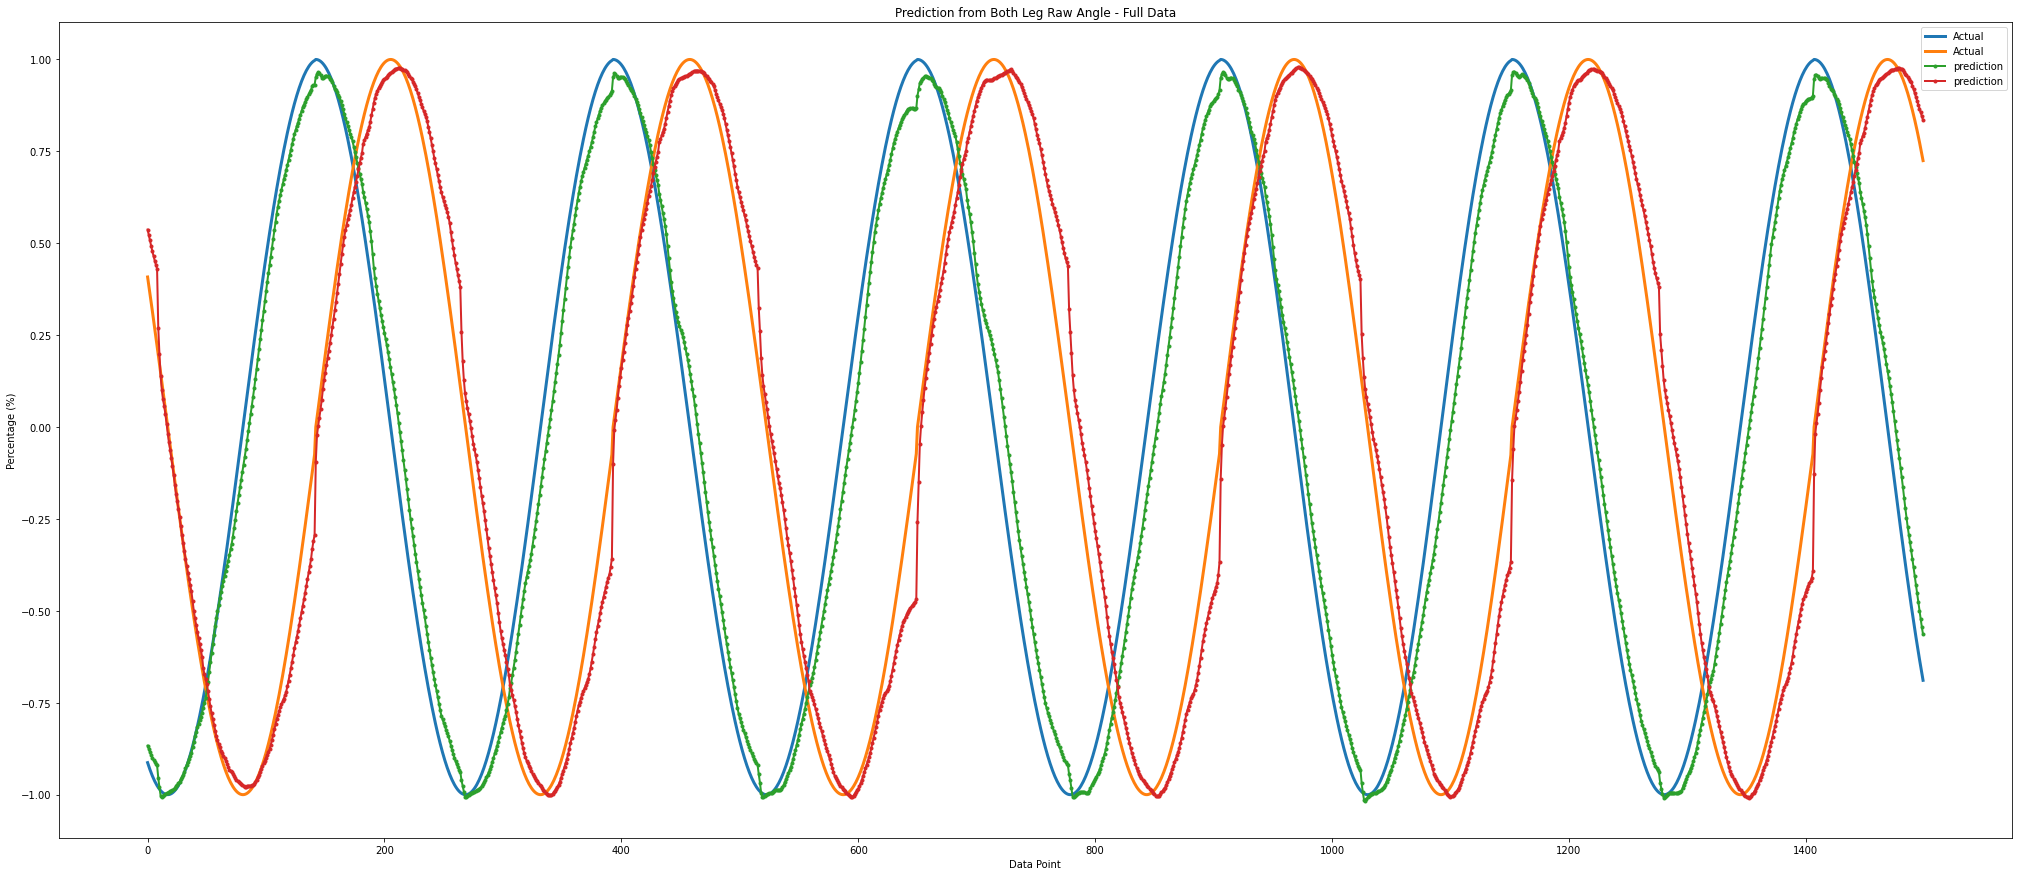

In [141]:
fig=plt.figure(figsize=(35,15))

plt.plot(y_test[0:1500],'-',label='Actual', linewidth = 3)
plt.plot(relu_model_pred[0:1500],'.-',label='prediction', linewidth = 2)



#plt.plot(actual[350:556],Rfoot[350:556],'.',label='Actual')
#plt.plot(pred[350:556],Rfoot[350:556],'.',label='prediction')

plt.legend()
plt.title('Prediction from Both Leg Raw Angle - Full Data')
#plt.title('Right Foot')
#plt.ylabel('Angle')
#plt.xlabel('Gait Cycle Percentage')
plt.xlabel('Data Point')
plt.ylabel('Percentage (%)')

In [142]:
print(y_test[134:145])

print(relu_model_pred[134:145])

[[ 0.96955986 -0.24485438]
 [ 0.97531957 -0.22079796]
 [ 0.98048249 -0.19660644]
 [ 0.98504546 -0.17229462]
 [ 0.9890057  -0.14787737]
 [ 0.99236079 -0.12336964]
 [ 0.99510866 -0.09878642]
 [ 0.99724764 -0.07414275]
 [ 1.          0.        ]
 [ 0.99969163  0.02483217]
 [ 0.99876673  0.04964903]]
[[ 0.89129776 -0.43142116]
 [ 0.89842695 -0.41256443]
 [ 0.9049011  -0.39489645]
 [ 0.91106194 -0.37811798]
 [ 0.917918   -0.35926405]
 [ 0.92694265 -0.3313042 ]
 [ 0.92985374 -0.31061935]
 [ 0.9313878  -0.293144  ]
 [ 0.9518227  -0.09441518]
 [ 0.96097    -0.02250996]
 [ 0.96595615  0.00310089]]


In [143]:
print(X_test[134:145])


[[0.90661332 0.115625   0.89656591 0.         0.84470869 0.23622988
  0.61801284 0.5136831  0.17124873 0.70915517]
 [0.90558865 0.12692126 0.89600526 0.         0.84761264 0.23289879
  0.61564893 0.50878571 0.17002653 0.7136917 ]
 [0.90441535 0.13550679 0.89426692 0.         0.85022501 0.22931245
  0.61213937 0.50410869 0.16871444 0.71815648]
 [0.90309167 0.14525958 0.89152241 0.         0.85246137 0.22541616
  0.60861741 0.49968804 0.16732651 0.72255374]
 [0.90154767 0.16018298 0.88777231 0.         0.85422099 0.22130654
  0.60561427 0.49521805 0.16588235 0.72688974]
 [0.89985679 0.17827049 0.88333839 0.         0.85540375 0.21714953
  0.60281211 0.49057949 0.16440803 0.73117051]
 [0.8979281  0.19526792 0.8786043  0.         0.8559165  0.21282112
  0.59994266 0.48584883 0.1629369  0.73540171]
 [0.89564445 0.209545   0.87382272 0.         0.85566076 0.20809707
  0.59681381 0.4811305  0.16151052 0.73958809]
 [0.88759047 0.23573571 0.86169737 0.03017117 0.84900445 0.19258847
  0.58714038

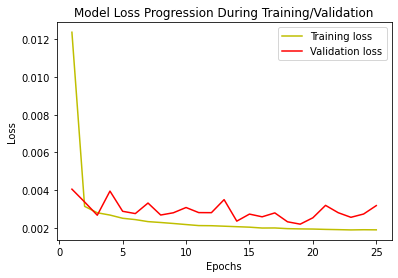

In [144]:
#for epoch in epoch_list:
#  loss= epoch.history['loss']
#  val_loss=epoch.history['val_loss']
#  epochs=range(1,len(loss)+1)
#  plt.plot(epochs, loss, 'y', label='Training loss')
#  plt.plot(epochs, val_loss, 'r', label='Validation loss')
#plt.title('Model Loss Progression During Training/Validation')
#plt.xlabel('Epochs')
#plt.ylabel('Loss')
#plt.legend()

loss= epoch.history['loss']
val_loss=epoch.history['val_loss']
epochs=range(1,len(loss)+1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Model Loss Progression During Training/Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [145]:
pred = np.zeros((len(relu_model_pred),1))

for iter in range(len(relu_model_pred)):
  x = relu_model_pred[iter][0]
  y = relu_model_pred[iter][1]
  pred[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))

pred1=pd.DataFrame(pred).sort_index().reset_index()
#print(pred[350:566])

In [146]:
actual = np.zeros((len(y_test),1))

for iter in range(len(y_test)):
  x = y_test[iter][0]
  y = y_test[iter][1]
  actual[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))

actual1 = pd.DataFrame(actual).sort_index().reset_index()
# print(actual[0:214]) #182:382

In [160]:
#angle_raw_dict = angle_raw_dict[(angle_raw_dict['perc']>=1) & (angle_raw_dict['perc']<=99)]
rmse = 0
length = len(actual)
for i in range(len(actual)):
  if abs (pred[i] - actual[i]) >= 90:
    length -= 1
  else:
    rmse = rmse + pow(pred[i] - actual[i], 2)
rmse = rmse / len(actual)
rmse = math.sqrt(rmse)
print(length)
print(rmse)

13611
1.6424216121725452


In [148]:
from sklearn.metrics import mean_squared_error
#print("MSE",mean_squared_error(actual,pred))
print("% RMSE", mean_squared_error(actual, pred, squared=False))


% RMSE 8.519861507083057


In [149]:
correct = 0
for iter in range(len(actual)):
  if (abs(actual[iter] - pred[iter]) <= 2):
    correct+=1

print(correct)
print(len(actual))

print("Precision: ", correct * 100/len(actual))


10430
13709
Precision:  76.08140637537385


Text(0, 0.5, 'Percentage (%)')

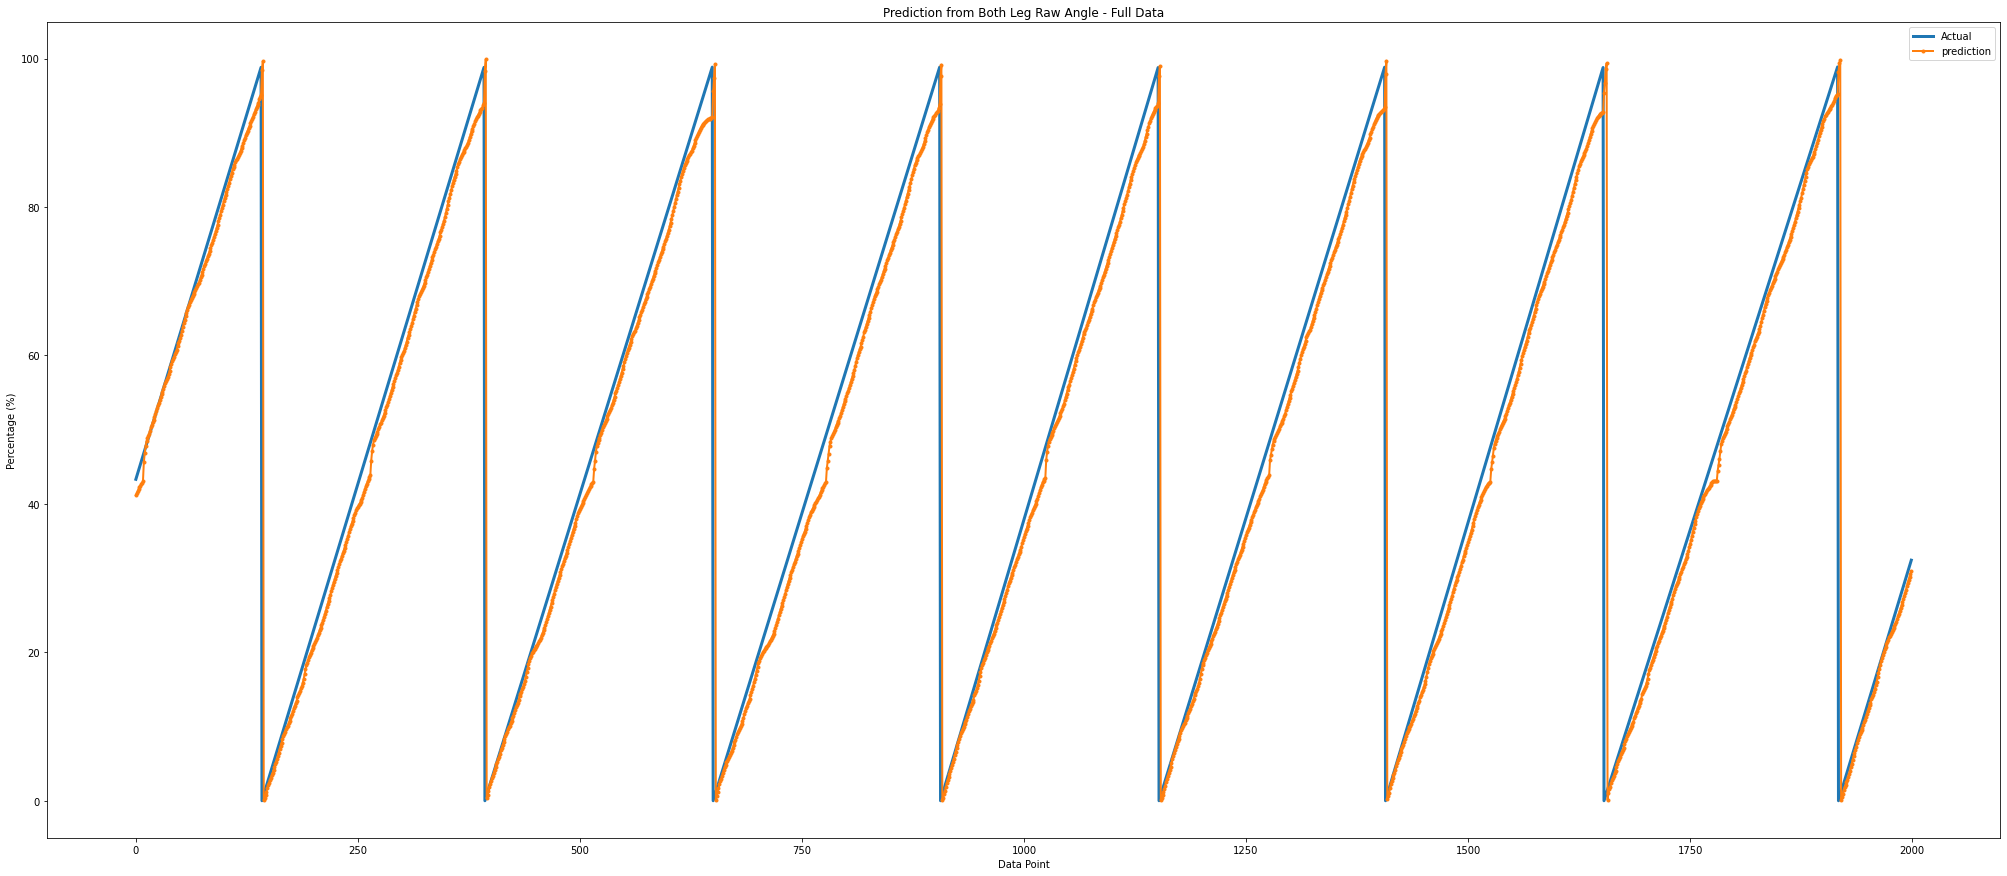

In [150]:
#plt.plot(Y[52272:52470],LShank[52272:52470],'--',label='Actual')
#plt.plot(pred,LShank,'--',label='prediction')
fig=plt.figure(figsize=(35,15))

plt.plot(actual[0:2000],'-',label='Actual', linewidth = 3)
plt.plot(pred[0:2000],'.-',label='prediction', linewidth = 2)

#plt.plot(actual,'-',label='Actual', linewidth = 3)
#plt.plot(pred,'.-',label='prediction', linewidth = 2)

#plt.plot(actual[350:556],Rfoot[350:556],'.',label='Actual')
#plt.plot(pred[350:556],Rfoot[350:556],'.',label='prediction')

plt.legend()
plt.title('Prediction from Both Leg Raw Angle - Full Data')
#plt.title('Right Foot')
#plt.ylabel('Angle')
#plt.xlabel('Gait Cycle Percentage')
plt.xlabel('Data Point')
plt.ylabel('Percentage (%)')

In [151]:
print(actual[139:395])

[[98.03149606]
 [98.42519685]
 [98.81889764]
 [ 0.        ]
 [ 0.39525692]
 [ 0.79051383]
 [ 1.18577075]
 [ 1.58102767]
 [ 1.97628458]
 [ 2.3715415 ]
 [ 2.76679842]
 [ 3.16205534]
 [ 3.55731225]
 [ 3.95256917]
 [ 4.34782609]
 [ 4.743083  ]
 [ 5.13833992]
 [ 5.53359684]
 [ 5.92885375]
 [ 6.32411067]
 [ 6.71936759]
 [ 7.11462451]
 [ 7.50988142]
 [ 7.90513834]
 [ 8.30039526]
 [ 8.69565217]
 [ 9.09090909]
 [ 9.48616601]
 [ 9.88142292]
 [10.27667984]
 [10.67193676]
 [11.06719368]
 [11.46245059]
 [11.85770751]
 [12.25296443]
 [12.64822134]
 [13.04347826]
 [13.43873518]
 [13.83399209]
 [14.22924901]
 [14.62450593]
 [15.01976285]
 [15.41501976]
 [15.81027668]
 [16.2055336 ]
 [16.60079051]
 [16.99604743]
 [17.39130435]
 [17.78656126]
 [18.18181818]
 [18.5770751 ]
 [18.97233202]
 [19.36758893]
 [19.76284585]
 [20.15810277]
 [20.55335968]
 [20.9486166 ]
 [21.34387352]
 [21.73913043]
 [22.13438735]
 [22.52964427]
 [22.92490119]
 [23.3201581 ]
 [23.71541502]
 [24.11067194]
 [24.50592885]
 [24.90118

In [152]:
print(actual[134:145])
print(pred[134:145])

[[96.06299213]
 [96.45669291]
 [96.8503937 ]
 [97.24409449]
 [97.63779528]
 [98.03149606]
 [98.42519685]
 [98.81889764]
 [ 0.        ]
 [ 0.39525692]
 [ 0.79051383]]
[[9.28253602e+01]
 [9.31486267e+01]
 [9.34510196e+01]
 [9.37389130e+01]
 [9.40625322e+01]
 [9.45367484e+01]
 [9.48688912e+01]
 [9.51469950e+01]
 [9.84264247e+01]
 [9.96272604e+01]
 [5.10914163e-02]]


Text(0.5, 1.0, 'Actual vs Prediction')

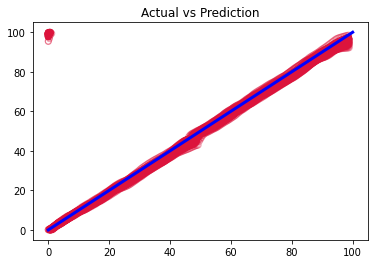

In [153]:
plt.scatter(actual, pred, facecolors='none', edgecolors='crimson',alpha=0.4)
p1 = max(max(pred), max(actual))
p2 = min(min(pred), min(actual))

ci = 0.1 * np.std([p1,p2]) / np.mean([p1,p2])

plt.plot([p1, p2], [p1, p2], 'b-', linewidth =3)
plt.title('Actual vs Prediction')




**Testing on other Subject**

In [154]:
test_excel_name= 'TH_final_3.xlsx' 

test_table = pd.read_excel(excel_path + test_excel_name, sheet_name='raw_data')
encode_gait_percentage(test_table, 'perc')

test_table.keys()

Index(['l_hip', 'l_foot', 'l_ank', 'l_shank', 'perc', 'l_grf', 'r_grf',
       'r_hip', 'r_foot', 'r_ank', 'r_shank', 'r_cop', 'l_cop', 's_l_cop',
       's_r_cop', 'x', 'y'],
      dtype='object')

In [155]:

test_table = test_table[test_table.perc > 0]
test_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95087 entries, 0 to 95542
Data columns (total 17 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   l_hip    95087 non-null  float64
 1   l_foot   95087 non-null  float64
 2   l_ank    95087 non-null  float64
 3   l_shank  95087 non-null  float64
 4   perc     95087 non-null  float64
 5   l_grf    95087 non-null  float64
 6   r_grf    95087 non-null  float64
 7   r_hip    95087 non-null  float64
 8   r_foot   95087 non-null  float64
 9   r_ank    95087 non-null  float64
 10  r_shank  95087 non-null  float64
 11  r_cop    95087 non-null  float64
 12  l_cop    95087 non-null  float64
 13  s_l_cop  95087 non-null  float64
 14  s_r_cop  95087 non-null  float64
 15  x        95087 non-null  float64
 16  y        95087 non-null  float64
dtypes: float64(17)
memory usage: 13.1 MB


In [156]:
data_x_test = test_table.drop(["perc", "x", "y"], axis = 1)

target_test = test_table[["x", "y"]]

In [157]:
scaler2 = MinMaxScaler()
data_test = scaler2.fit_transform(data_x_test)

target_test = target_test.values.reshape(-1,2)

In [158]:
other_sub_pred = model.predict(data_test)

print("RMSE - test on other sub: ", mean_squared_error(target_test, other_sub_pred, squared=False)) 

InvalidArgumentError: Graph execution error:

Detected at node 'sequential_9/dense_27/Relu' defined at (most recent call last):
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\Admin\AppData\Roaming\Python\Python38\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\Admin\AppData\Roaming\Python\Python38\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\Admin\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "C:\Users\Admin\AppData\Roaming\Python\Python38\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Admin\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\Admin\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\Admin\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\Admin\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\Admin\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py", line 418, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\Admin\AppData\Roaming\Python\Python38\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\interactiveshell.py", line 2898, in run_cell
      result = self._run_cell(
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\interactiveshell.py", line 2944, in _run_cell
      return runner(coro)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\interactiveshell.py", line 3169, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\interactiveshell.py", line 3361, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Admin\AppData\Local\Temp\ipykernel_21680\3096089944.py", line 1, in <module>
      other_sub_pred = model.predict(data_test)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 2350, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 2137, in predict_function
      return step_function(self, iterator)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 2123, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 2111, in run_step
      outputs = model.predict_step(data)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 2079, in predict_step
      return self(x, training=False)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\sequential.py", line 413, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\layers\core\dense.py", line 255, in call
      outputs = self.activation(outputs)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\backend.py", line 5369, in relu
      x = tf.nn.relu(x)
Node: 'sequential_9/dense_27/Relu'
Matrix size-incompatible: In[0]: [32,14], In[1]: [10,100]
	 [[{{node sequential_9/dense_27/Relu}}]] [Op:__inference_predict_function_3591157]

In [ ]:
pred_1 = np.zeros((len(other_sub_pred), 1))

for iter in range(len(other_sub_pred)):
    x = other_sub_pred[iter][0]
    y = other_sub_pred[iter][1]
    pred_1[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))



In [ ]:
pred_1

array([[69.25307747],
       [69.26338851],
       [69.28227509],
       ...,
       [71.886364  ],
       [71.88499863],
       [71.88468216]])

In [ ]:
actual_1 = np.zeros((len(target_test),1))

for iter in range(len(target_test)):
    x = target_test[iter][0]
    y = target_test[iter][1]
    actual_1[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))

In [ ]:
actual_1

array([[ 0.29761905],
       [ 0.5952381 ],
       [ 0.89285714],
       ...,
       [98.91304348],
       [99.45652174],
       [ 0.        ]])

In [ ]:
print("% RMSE - test other subject: ", mean_squared_error(actual_1, pred_1, squared =False))

% RMSE - test other subject:  43.80577209937412


In [ ]:
correct_1 = 0
for iter in range(len(actual_1)):
  if (abs(actual_1[iter] - pred_1[iter]) <= 5):
    correct_1+=1

print(correct_1)
print(len(actual_1))

print("Precision: ", correct_1 * 100/len(actual_1))

9512
95088
Precision:  10.003365303718661


Text(0, 0.5, 'Percentage (%)')

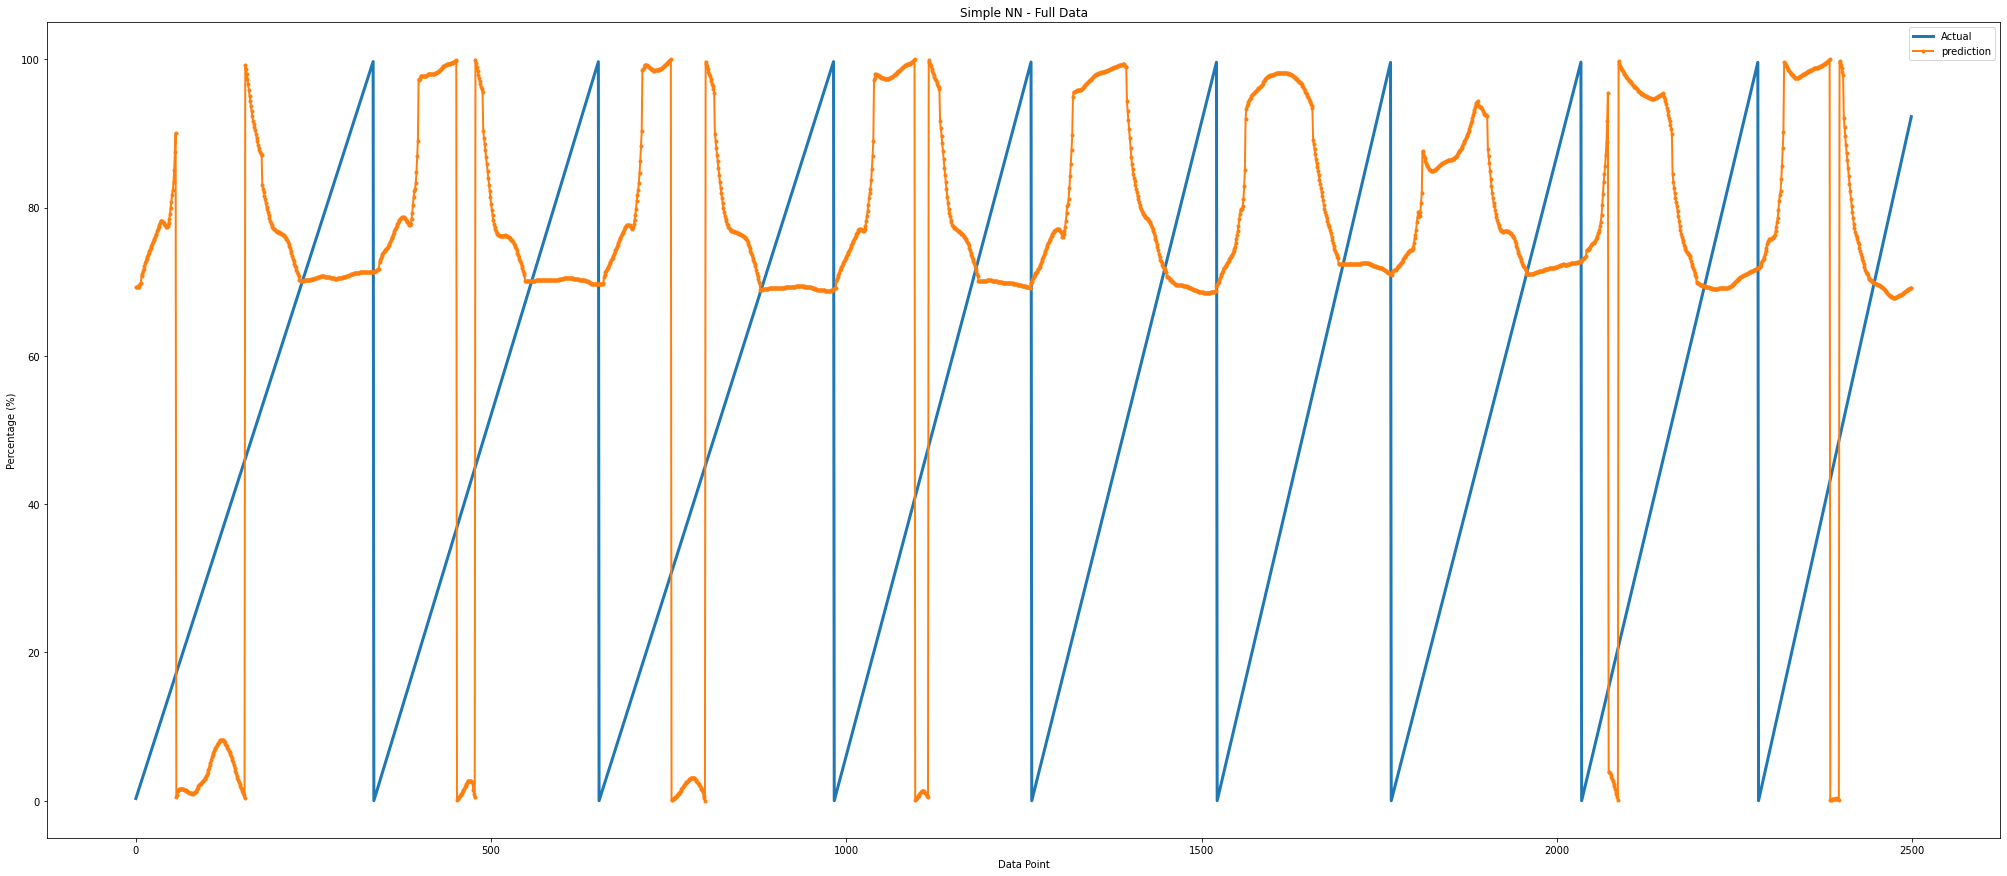

In [ ]:
fig=plt.figure(figsize=(35,15))

plt.plot(actual_1[0:2500],'-',label='Actual', linewidth = 3)
plt.plot(pred_1[0:2500],'.-',label='prediction', linewidth = 2)



#plt.plot(actual[350:556],Rfoot[350:556],'.',label='Actual')
#plt.plot(pred[350:556],Rfoot[350:556],'.',label='prediction')

plt.legend()
plt.title('Simple NN - Full Data')
#plt.title('Right Foot')
#plt.ylabel('Angle')
#plt.xlabel('Gait Cycle Percentage')
plt.xlabel('Data Point')
plt.ylabel('Percentage (%)')

Text(0.5, 1.0, 'Actual vs Prediction')

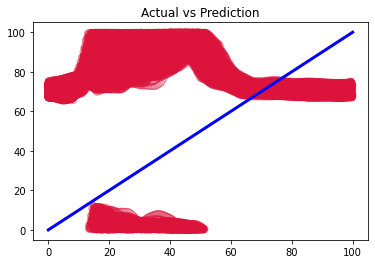

In [ ]:
plt.scatter(actual_1, pred_1, facecolors='none', edgecolors='crimson',alpha=0.4)
p1 = max(max(pred_1), max(actual_1))
p2 = min(min(pred_1), min(actual_1))

ci = 0.1 * np.std([p1,p2]) / np.mean([p1,p2])

plt.plot([p1, p2], [p1, p2], 'b-', linewidth =3)
plt.title('Actual vs Prediction')

In [ ]:

#%cd /content/drive/MyDrive/
#model.save('Gait Predict/Model/single_1_phase_left_leg.hdf5')
